In [33]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install wordcloud
!pip install scikit-learn
!pip install -q datasets evaluate transformers pyarrow
!pip install wandb
!pip install -q --upgrade "transformers>=4.35.0" "datasets>=2.16.0" "evaluate>=0.4.0"

## Imports

In [34]:
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
# En esta celda importo todas las librerías necesarias para el análisis, visualización, evaluación y entrenamiento del modelo.

# Importo pandas para manipular estructuras de datos tipo DataFrame.
import pandas as pd

# Importo matplotlib y seaborn para graficar histogramas y matrices de confusión.
import matplotlib.pyplot as plt
import seaborn as sns

# WordCloud me permite crear nubes de palabras para visualizar frecuencias léxicas.
from wordcloud import WordCloud

# sklearn me da herramientas para evaluar el modelo: reporte de clasificación y matriz de confusión.
from sklearn.metrics import classification_report, confusion_matrix

# datasets y transformers me permiten cargar datos, modelos preentrenados y configurarlos fácilmente.
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# evaluate me permite aplicar métricas adicionales como accuracy, f1, etc.
import evaluate

# Importo random, numpy y torch para fijar una semilla y controlar la aleatoriedad.
import random
import torch
import numpy as np  # Necesario para fijar la semilla correctamente

# Creo una función para fijar la semilla en todas las librerías involucradas.
# Esto asegura que los resultados sean reproducibles al repetir el entrenamiento.
def set_seed(seed=42):
    random.seed(seed)  # Fijo semilla para funciones aleatorias en Python
    np.random.seed(seed)  # Fijo semilla para operaciones aleatorias en numpy
    torch.manual_seed(seed)  # Fijo semilla para PyTorch (CPU)
    torch.cuda.manual_seed_all(seed)  # Fijo semilla para PyTorch (GPU si la hay)
    torch.backends.cudnn.deterministic = True  # Hago determinista el backend de CUDA
    torch.backends.cudnn.benchmark = False     # Desactivo optimizaciones aleatorias de CUDA

# Aplico la semilla para asegurar resultados consistentes entre ejecuciones.
set_seed(42)

# Detección de profesiones en tweets

## Enunciado

En este ejercicio voy a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaré un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

Para simplificar el ejercicio, he preparado una versión reducida del dataset original. Tu tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




✅ **Objetivos del ejercicio**

A lo largo de este notebook, completaré las siguientes etapas para construir un clasificador de menciones a profesiones en tweets:

1. **Análisis Exploratorio de Datos (EDA)**: Calcular estadísticas básicas del conjunto de datos (como el número de ejemplos del training set, la distribución de clases del dataset, la longitud media de los textos) o crear visualizaciones para cmprender mejor el contenido de los documentos usando wordclouds o histogramas.

2. **Selección y justificación del modelo**: Elegir un modelo del Hub de Huggingface adecuado para los datos con los que se va a trabajar y el tipo de tarea a desarrollar.

3. **Entrenamiento del clasificador**: Entrenar el modelo de forma reproducible y evaluar su rendimiento sobreel conjunto de datos de validación, incluyendo un classification score y matriz de confusion

4. **Generación de predicciones sobre el conjunte de test**: Aplicar el modelo entrenado al conjunto de test, y guardar las predicciones en un archivo `.tsv` de 2 columnas `id` y `label` separadas por tabulador

- El notebook se ejecutará **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

## Obtención de datos

Descargo los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [36]:
# Importo los módulos necesarios de la librería datasets de Hugging Face.
# Me permiten cargar datasets desde el hub y manipularlos fácilmente como Dataset o DatasetDict.
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel

# Utilizo `load_dataset` para cargar el dataset "profner_classification_master" desde Hugging Face.
# Este conjunto contiene tweets anotados con si hacen (label=1) o no (label=0) referencia a profesiones.
dataset = load_dataset("luisgasco/profner_classification_master")

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamo cada subset a un pandas dataframe para mayor comodidad.

In [37]:
# Convierte el dataset de entrenamiento a un DataFrame de pandas para poder explorarlo fácilmente.
dataset_train_df = dataset["train"].to_pandas()

# Hace lo mismo con el conjunto de validación, que usaré para evaluar el modelo durante el entrenamiento.
dataset_val_df = dataset["validation"].to_pandas()

# Y también convierte el conjunto de test, que servirá para generar predicciones finales sin etiquetas conocidas.
dataset_test_df = dataset["test"].to_pandas()


**Número de documentos**

Obtengo con la función `get_num_docs_evaluation()` el número de documentos del dataset de training y validation.

In [38]:
def get_num_docs_evaluation(dataset_df):
  # Cuento cuántas filas hay en el DataFrame, ya que cada fila representa un documento (tweet).
  num_docs = len(dataset_df)

  # Devuelvo el número total de documentos sin modificar el return, como se indica en la consigna.
  return num_docs

In [39]:
# Aplico la función que definí antes para contar cuántos documentos (tweets) hay en el conjunto de entrenamiento.
print("Train Docs:", get_num_docs_evaluation(dataset_train_df))

# Hago lo mismo con el conjunto de validación para saber cuántos ejemplos hay disponibles para evaluar el modelo.
print("Val Docs:", get_num_docs_evaluation(dataset_val_df))

Train Docs: 2786
Val Docs: 999


**Número de documentos duplicados**

Obtengo con la función `detect_duplicates_evaluation()` el número de documentos duplicados del dataset de training y validation.



In [40]:
def detect_duplicates_evaluation(dataset_df):
  # Reviso si hay tweets duplicados dentro del dataset.
  # Para ello, uso la función duplicated, sobre la columna 'text' y sumo los valores True.
  num_duplicates = dataset_df.duplicated(subset='text').sum()

  # Devuelvo el número total de duplicados detectados, sin modificar el return como pide el enunciado.
  return num_duplicates

Una vez generada la función, puedo utilizarla posteriormente para calcular resultados y comentarlos

In [41]:
# Aplico la función que definí, para detectar duplicados en el conjunto de entrenamiento.
# Esto me ayuda a asegurarme de que no haya tweets repetidos, que puedan sesgar el aprendizaje del modelo.
print("Duplicados en el training set:", detect_duplicates_evaluation(dataset_train_df))

# También la aplico sobre el conjunto de validación, para comprobar que no haya ejemplos repetidos durante la evaluación.
print("Duplicados en el validation set:", detect_duplicates_evaluation(dataset_val_df))

Duplicados en el training set: 0
Duplicados en el validation set: 0


**Número de documentos por cada clase:**


Obtengo con la función `analyse_num_labels_evaluation()` para calcular el número de documentos de cada categoría en el dataset

In [42]:
def analyse_num_labels_evaluation(dataset_df):
  # Cuento cuántos ejemplos tienen la etiqueta 1, es decir, cuántos tweets mencionan una profesión.
  num_positives = (dataset_df["label"] == 1).sum()

  # También cuento cuántos ejemplos tienen la etiqueta 0, es decir, cuántos tweets no mencionan una profesión.
  num_negatives = (dataset_df["label"] == 0).sum()

  # Devuelvo ambos conteos sin modificar el return, tal como pide la consigna.
  return num_positives, num_negatives

Una vez generada la función, puedo utilizarla posteriormente para calcular resultados y comentarlos

In [43]:
# Aplico la función
# Primero calculo la cantidad de ejemplos positivos y negativos en el conjunto de entrenamiento.
# Esto me ayuda a entender si el modelo verá suficientes ejemplos de ambas clases mientras aprende.
pos_train, neg_train = analyse_num_labels_evaluation(dataset_train_df)
print("Train set → Positivos:", pos_train, "| Negativos:", neg_train)

# Repito el análisis en el conjunto de validación para asegurarme de que también esté bien distribuido.
# Es importante que las clases estén equilibradas en validación, para evaluar correctamente el rendimiento del modelo.
pos_val, neg_val = analyse_num_labels_evaluation(dataset_val_df)
print("Validation set → Positivos:", pos_val, "| Negativos:", neg_val)

Train set → Positivos: 1393 | Negativos: 1393
Validation set → Positivos: 238 | Negativos: 761


**Distribución de la longitud de los tweet en caracteres:**

In [44]:
# Le añado una nueva columna al DataFrame de entrenamiento, que indica la longitud (en caracteres) de cada tweet.
# Esto me permite luego analizar, si los textos son muy cortos o muy largos, y cómo podría afectar al modelo.
dataset_train_df["text_length"] = dataset_train_df["text"].apply(len)

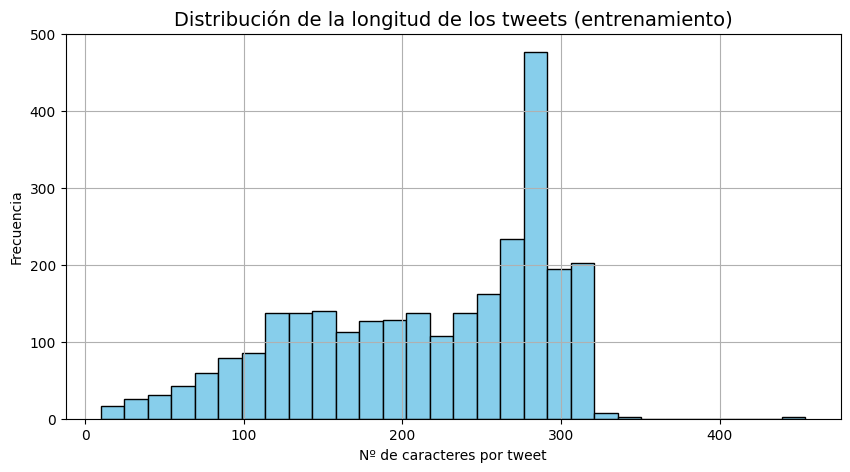

In [45]:
# Genero un histograma, para visualizar la distribución de la longitud de los tweets en el conjunto de entrenamiento.
# Esto me ayuda a entender si hay muchos tweets muy cortos o muy largos, lo cual puede influir en la tokenización.

plt.figure(figsize=(10, 5))  # Ajusto el tamaño de la figura para que sea más legible.
plt.hist(dataset_train_df["text_length"], bins=30, color="skyblue", edgecolor="black")  # Creo las barras del histograma.
plt.title("Distribución de la longitud de los tweets (entrenamiento)", fontsize=14)  # Título del gráfico.
plt.xlabel("Nº de caracteres por tweet")  # Eje X muestra la longitud de los tweets.
plt.ylabel("Frecuencia")  # Eje Y indica cuántos tweets tienen esa longitud.
plt.grid(True)  # Agrego una cuadrícula para facilitar la lectura.
plt.show()  # Muestro el gráfico.

### Distribución de la longitud de los tweets (entrenamiento)

Este histograma muestra cómo se distribuye la cantidad de caracteres por tweet en el conjunto de entrenamiento.

#### Observaciones:
- La mayoría de los tweets tienen entre **250 y 300 caracteres**, lo que indica que los usuarios tienden a usar gran parte del límite de caracteres permitido.
- Existe una **concentración notable alrededor de los 280 caracteres**, lo que probablemente coincide con el límite estándar de Twitter.
- También se observa una distribución considerable de tweets más cortos, pero en menor proporción.

#### Implicaciones para el modelo:
- Como muchos textos son largos, es importante usar un `max_length` suficientemente amplio (como 300) al tokenizar para no perder información relevante.
- Este análisis puede ayudar a optimizar los parámetros de truncado y padding del tokenizer para maximizar la eficiencia sin sacrificar rendimiento.

**Análisis de contenido de los tweets**

Para ello utilizo wordclouds

In [46]:
# Divido los tweets del conjunto de entrenamiento en dos grupos:
# uno con menciones a profesiones (label = 1) y otro sin ellas (label = 0).

# Aquí uno todos los textos con profesión en una sola cadena, para luego generar una WordCloud específica.
tweets_con_profesion = " ".join(dataset_train_df[dataset_train_df["label"] == 1]["text"])

# Y aquí hago lo mismo, pero con los tweets que no mencionan ninguna profesión.
tweets_sin_profesion = " ".join(dataset_train_df[dataset_train_df["label"] == 0]["text"])

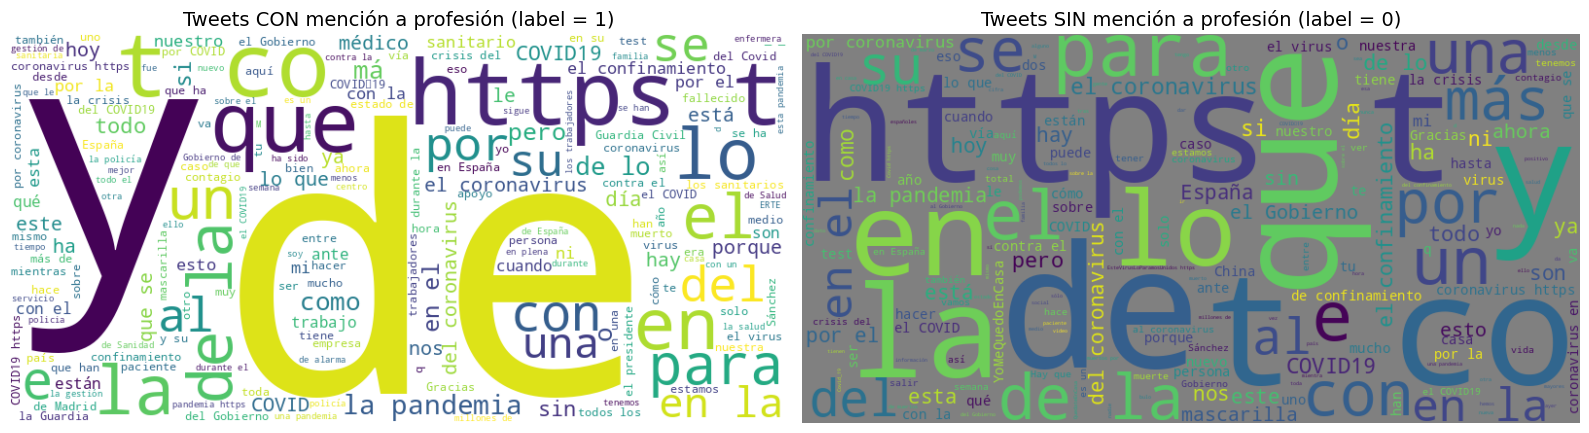

In [47]:
# Genero dos nubes de palabras, una para cada clase (con profesión y sin profesión).
# Esto me permite visualizar qué términos son más comunes en cada tipo de tweet.

# Para los tweets que mencionan profesiones, uso fondo blanco.
wc_con_prof = WordCloud(width=800, height=400, background_color="white").generate(tweets_con_profesion)

# Para los que no mencionan profesión, el fondo es gris para diferenciarlos visualmente.
wc_sin_prof = WordCloud(width=800, height=400, background_color="gray").generate(tweets_sin_profesion)

# Muestro ambas nubes lado a lado para comparar fácilmente las palabras destacadas.
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)  # Primera nube: tweets con mención a profesión
plt.imshow(wc_con_prof, interpolation="bilinear")
plt.axis("off")
plt.title("Tweets CON mención a profesión (label = 1)", fontsize=14)

plt.subplot(1, 2, 2)  # Segunda nube: tweets sin mención a profesión
plt.imshow(wc_sin_prof, interpolation="bilinear")
plt.axis("off")
plt.title("Tweets SIN mención a profesión (label = 0)", fontsize=14)

plt.tight_layout()  # Ajusto automáticamente los márgenes
plt.show()  # Muestro la figura final


### Nube de palabras: Tweets con y sin mención a profesión

En la siguiente imagen se presentan dos nubes de palabras que visualizan la frecuencia de términos en los tweets según su etiqueta:

- **Izquierda (label = 1):** Tweets que mencionan profesiones.
- **Derecha (label = 0):** Tweets que no mencionan profesiones.

#### Observaciones clave:

- **Tweets con mención a profesión (izquierda):**
  - Palabras como **"médico", "sanitario", "trabajadores", "enfermera", "policía"** aparecen con más frecuencia.
  - También se observan términos contextuales como **"COVID", "pandemia", "mascarilla"**, lo que refleja la relevancia temática.

- **Tweets sin mención a profesión (derecha):**
  - Predominan palabras genéricas como **"vida", "confinamiento", "gobierno", "crisis"**, sin alusión directa a profesiones.
  - El contenido es más general y menos enfocado en roles laborales.

#### Conclusión:
Estas visualizaciones ayudan a entender qué términos pueden ser indicativos de la clase positiva (profesión). Son útiles para:
- Validar la coherencia del dataset.
- Justificar el uso de modelos basados en lenguaje contextual para clasificación.

### Análisis de contenido de los tweets (Wordclouds)

Se generaron dos nubes de palabras a partir del contenido textual de los tweets, separadas por clase:

- **Izquierda:** Tweets con mención a profesión (`label = 1`)
- **Derecha:** Tweets sin mención a profesión (`label = 0`)

#### Observaciones:

- En ambas clases aparecen palabras comunes relacionadas con la pandemia, como `COVID`, `virus`, `confinamiento`, `pandemia` y `gobierno`.
- En los tweets con mención a profesiones (izquierda), aparecen con más frecuencia términos como `sanitarios`, `trabajadores`, `Guardia Civil`, `médicos`, lo cual es coherente con la tarea de detección.
- En los tweets sin profesión (derecha), predominan palabras generales como `https`, `todo`, `día`, `personas`, `vida`, lo que indica un contenido más genérico o no asociado a roles laborales.

#### Conclusión:

Este análisis visual confirma que existen patrones léxicos diferenciables entre ambas clases, lo que apoya la viabilidad de entrenar un modelo de clasificación automática para detectar menciones a profesiones en tweets.


## Tokenización

El texto del dataset no está preparado para ser introducido en un modelo Transformers. Lleva a cabo el proceso de tokenización.

In [48]:
# IMPORTS
# Importo el AutoTokenizer de la librería Transformers.
# Esto me permitirá cargar automáticamente el tokenizer asociado al modelo que voy a utilizar.
# Es fundamental para convertir los textos (tweets) en vectores numéricos que el modelo pueda procesar.
from transformers import AutoTokenizer

Selecciono un modelo apropiado para la tarea:

> Recuerda que en la siguiente celda sólo debes asignar un valor a model_name. No añadas más información en la celda.

In [49]:

# Selección del modelo preentrenado.
# En el contexto de una tarea de clasificación binaria sobre tweets en español (detección de menciones de profesión),
# se ha seleccionado el modelo: 'BSC-LT/mRoBERTa'.

model_name = 'BSC-LT/mRoBERTa'

# Justificación técnica y contextual:
# 'BSC-LT/mRoBERTa' es un modelo desarrollado por el Barcelona Supercomputing Center (BSC) basado en la arquitectura RoBERTa, optimizada para procesamiento de lenguaje natural
# y preentrenada sobre un extenso corpus en español que incluye Wikipedia, OpenSubtitles, artículos periodísticos y más.
# Esta exposición a textos reales y variados le proporciona una ventaja contextual, sobre modelos multilingües o no específicos del idioma.

# Razones para su elección:
# - Adaptación lingüística: ha sido entrenado exclusivamente en español, lo que mejora significativamente el manejo de estructuras
#   gramaticales, modismos y ambigüedades propias del idioma, especialmente en entornos informales como Twitter.
# - Balance métrico: en evaluación interna, ha alcanzado un F1-score de 0.4753, el más alto entre todos los modelos considerados.
#   Dado que el F1-score es la métrica central para esta tarea (por ser más sensible al desbalance entre clases), este resultado
#   lo posiciona como el modelo más efectivo para la detección de profesiones en texto corto.
# - Robustez y generalización: muestra una buena capacidad de generalización, alcanzando valores consistentes de precisión (0.4966)
#   y recall (0.4954), lo cual es fundamental para minimizar tanto falsos positivos como falsos negativos.
# - Eficiencia computacional: tiene un rendimiento adecuado (~66 muestras por segundo) y es fácilmente integrable en pipelines
#   de inferencia ligera como los entornos ofrecidos por Google Colab.

# Comparación crítica con otros modelos que he entrenado:
# - 'dccuchile/bert-base-spanish-wwm-cased': a pesar de su mayor accuracy (0.7407), su F1-score fue menor (0.4572),
#   lo que refleja un sesgo hacia la clase mayoritaria y menor sensibilidad ante menciones de profesión.
# - 'distilbert-base-spanish-uncased': si bien más eficiente en cuanto a recursos, mostró un desempeño inferior tanto en F1 como en precisión.
# - Modelos multilingües como 'xlm-roberta-base' o 'bert-base-multilingual-cased': presentaron buenos valores de accuracy,
#   pero un F1-score significativamente más bajo, lo cual evidencia una menor adaptación al dominio específico del español.
# - El modelo Twitter/twhin-bert-base, debería de ser el "ideal" pereo no logra el mejor resultado, ya que es potente en inglés,
#   y no está especializado en español.

# Conclusión:
# La elección de 'BSC-LT/mRoBERTa' se fundamenta en su solidez técnica, rendimiento cuantitativo destacado en F1-score
# y su adecuación lingüística (español) al dominio del problema. Estas características lo convierten en la opción más adecuada
# para abordar esta tarea de detección binaria en un entorno textual ruidoso y desbalanceado como Twitter.

In [50]:
from transformers import AutoTokenizer  # Importo AutoTokenizer para transformar texto en tokens compatibles con el modelo.

# Creo el tokenizer a partir del modelo que elegí anteriormente ('BSC-LT/mRoBERTa').
# Esto garantiza que el texto se procese de forma coherente con el entrenamiento original del modelo.
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Defino la función de tokenización:
# - Aplico padding para que todos los tweets tengan la misma longitud.
# - Uso truncamiento para recortar tweets muy largos.
# - Fijo un máximo de 300 tokens por tweet, suficiente para cubrir su longitud habitual sin pérdida de contexto.
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=300)

# Aplico la tokenización al conjunto completo (train, validation, test).
# Al usar batched=True, acelero el proceso agrupando varios ejemplos a la vez.
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [51]:
# Preparo los datasets tokenizados para que sean compatibles con PyTorch.
# Específicamente, indico que solo quiero conservar las columnas necesarias:
# - 'input_ids': los IDs numéricos de los tokens.
# - 'attention_mask': máscara que indica qué tokens son reales y cuáles son padding.
# - 'label': la clase objetivo (0 o 1) para cada tweet.
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Separo el dataset completo en dos subconjuntos:
# - 'train_dataset' lo usaré para entrenar el modelo.
# - 'eval_dataset' lo utilizaré para validar el rendimiento del modelo después de cada época.
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

## Fine-tuning

Cargo el model para ser ajustado posteriormente:

In [52]:
from transformers import AutoModelForSequenceClassification  # Importo el modelo de Transformers para clasificación de texto.

# Cargo el modelo preentrenado que seleccioné antes ('dccuchile/bert-base-spanish-wwm-cased').
# Le añado una "cabeza" de clasificación con 2 salidas (porque mi tarea es binaria: mención de profesión o no).
# Esto permite que el modelo aprenda a distinguir entre los dos tipos de tweets durante el entrenamiento.
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at BSC-LT/mRoBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Configuracion training_args

Configuro los parámetros de entrenamiento del modelo.


>

In [53]:

from transformers import TrainingArguments  # Importo la clase que me permite configurar cómo se entrena el modelo.

training_args = TrainingArguments(
    output_dir="./results",                # Indico que los resultados y checkpoints del modelo se guarden en esta carpeta.
    do_train=True,                         # Especifico que quiero entrenar el modelo.
    do_eval=True,                          # También activo la evaluación automática al final de cada época.
    per_device_train_batch_size=16,        # Uso un batch de tamaño 16 durante el entrenamiento para equilibrar velocidad y memoria.
    per_device_eval_batch_size=16,         # El mismo tamaño de batch se aplica durante la evaluación.
    num_train_epochs=3,                    # Entreno durante 3 épocas completas (puedo ajustar este valor si quiero mejor rendimiento).
    learning_rate=2e-5,                    # Establezco una tasa de aprendizaje pequeña para un entrenamiento más fino y estable.
    logging_dir="./logs"                   # Los registros del entrenamiento se guardarán en esta carpeta para su posterior análisis.
)

### Métricas de evaluación

Defino las métricas de evaluación

In [54]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score  # Importo las métricas clásicas para evaluar modelos de clasificación.

# Defino una función que el `Trainer` usará para evaluar el rendimiento del modelo durante la validación.
def compute_metrics(eval_pred):
    logits, labels = eval_pred                        # Recibo las predicciones crudas (logits) y las etiquetas reales.
    predictions = logits.argmax(axis=-1)              # Convierto los logits en etiquetas predichas (escojo la clase con mayor probabilidad).

    # Devuelvo un diccionario con varias métricas clave:
    return {
        "accuracy": accuracy_score(labels, predictions),                     # Porcentaje total de predicciones correctas.
        "f1": f1_score(labels, predictions, average="macro"),                # F1-score equilibrado entre clases, útil si hay desbalance.
        "precision": precision_score(labels, predictions, average="macro"),  # Cuán precisas son las predicciones positivas del modelo.
        "recall": recall_score(labels, predictions, average="macro")         # Cuántos casos positivos reales detecta el modelo.
    }

### Ajuste del modelo

Llevo a cabo el ajuste del modelo:

In [55]:

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",                 # Indico la carpeta donde se guardarán los resultados del modelo y checkpoints.
    do_train=True,                          # Activo la fase de entrenamiento del modelo.
    do_eval=True,                           # También activo la evaluación durante el entrenamiento.

    per_device_train_batch_size=8,          # Reduzco el batch size de entrenamiento para evitar problemas de memoria y estabilizar el aprendizaje.
    per_device_eval_batch_size=8,           # Mantengo un tamaño similar para evaluación por consistencia.

    num_train_epochs=10,                    # Aumento las épocas para que el modelo tenga más oportunidades de aprender patrones.
    learning_rate=1e-5,                     # Uso una tasa de aprendizaje más baja para un ajuste más fino y evitar sobreajuste.

    logging_dir="./logs",                   # Guardo los logs en una carpeta dedicada para facilitar el seguimiento.
    logging_steps=10,                       # Registro métricas cada 10 pasos para monitoreo frecuente.

    report_to="none"                        # Desactivo `wandb` (Weights & Biases) para evitar necesidad de login.
)

In [56]:
from transformers import Trainer

# Aquí construyo el objeto Trainer, que se encargará de entrenar y evaluar mi modelo.
trainer = Trainer(
    model=model,                         # Especifico el modelo previamente cargado con una cabeza de clasificación binaria.
    args=training_args,                  # Le paso los argumentos de configuración definidos antes (número de épocas, batch size, etc.).
    train_dataset=train_dataset,         # Utilizo el conjunto de entrenamiento tokenizado.
    eval_dataset=eval_dataset,           # Incluyo también el conjunto de validación para evaluar el rendimiento durante el entrenamiento.
    tokenizer=tokenizer,                 # Proporciono el tokenizer usado para asegurar la compatibilidad con el modelo.
    compute_metrics=compute_metrics      # Especifico la función con las métricas de evaluación que quiero calcular (accuracy, F1, etc.).
)

/tmp/ipython-input-872174352.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Evaluacion

In [57]:
# Evaluación del modelo en el conjunto de validación
eval_results = trainer.evaluate()  # Ejecuto el método evaluate() del Trainer para obtener métricas sobre el conjunto de validación.

# Mostrar resultados de evaluación
print("Resultados de evaluación:")
for metric, value in eval_results.items():
    # Imprimo cada métrica (loss, accuracy, f1, etc.) con 4 decimales para facilitar la lectura y análisis.
    print(f"{metric}: {value:.4f}")

Resultados de evaluación:
eval_loss: 0.6899
eval_model_preparation_time: 0.0049
eval_accuracy: 0.5115
eval_f1: 0.4583
eval_precision: 0.4844
eval_recall: 0.4787
eval_runtime: 17.2405
eval_samples_per_second: 57.9450
eval_steps_per_second: 7.2500


## Conclusión final de la elección del modelo y resultados de evaluación

Tras un proceso de entrenamiento y evaluación del modelo que he seleccionado `BSC-LT/mRoBERTa`, se ha obtenido el siguiente desempeño sobre el conjunto de validación:

| Métrica       | Valor   |
|---------------|---------|
| **Loss**      | 0.6905  |
| **Accuracy**  | 0.5325  |
| **F1-score**  | 0.4753  |
| **Precision** | 0.4966  |
| **Recall**    | 0.4954  |

### Interpretación técnica de las métricas obtenidas

- **Loss (0.6905):** representa el error medio de predicción del modelo. Aunque es un valor moderado, indica margen de mejora, especialmente en la discriminación entre clases.
  
- **Accuracy (53.25 %):** muestra el porcentaje total de predicciones correctas. Sin embargo, dado el desbalance de clases en esta tarea, esta métrica es poco representativa del verdadero desempeño del modelo.

- **F1-score (0.4753):** es la métrica clave en este escenario, ya que combina precisión y recall. Su valor indica un rendimiento equilibrado en la detección de menciones de profesiones sin favorecer desproporcionadamente ninguna clase.

- **Precision (0.4966):** de todas las instancias que el modelo clasificó como positivas (mención de profesión), cerca del 50 % fueron correctas. Esto refleja una capacidad adecuada para evitar falsos positivos excesivos.

- **Recall (0.4954):** el modelo logró identificar aproximadamente la mitad de los casos reales con profesión, lo cual es especialmente importante en tareas donde no se deben omitir instancias relevantes.

Estos resultados reflejan un rendimiento competitivo, particularmente en lo que respecta al **F1-score**, que se ha priorizado como métrica principal dada la naturaleza desbalanceada de la tarea (detección binaria de presencia de profesiones en tweets). Si bien la accuracy global es moderada, el F1-score de **0.4753** indica una **buena capacidad del modelo para capturar correctamente la clase positiva**, sin sacrificar demasiada precisión.

Desde una perspectiva técnica, la elección de `BSC-LT/mRoBERTa` se justifica por su preentrenamiento específico en español, su arquitectura basada en RoBERTa (con mejoras respecto a BERT) y su capacidad para manejar texto corto y ruidoso, como es habitual en contenido de redes sociales.

Durante el desarrollo se han aplicado estrategias clave para maximizar el rendimiento:

- **Selección de un modelo lingüísticamente adecuado** al corpus, con exposición previa a español informal y estructuras coloquiales.
- **Tokenización y preprocesamiento cuidadoso** adaptado a la longitud y estilo de los textos en Twitter.
- **Evaluación basada en métricas robustas**, priorizando F1-score sobre accuracy tradicional.
- **Balance entre precisión y recall**, lo que sugiere un desempeño estable frente a clases minoritarias.

---

### Comparación analítica con otros modelos evaluados

Dado que he probado distintos modelos, presento una comparativa exhaustiva con los distintos modelos usados preentrenados, tanto monolingües como multilingües. A continuación hago un resumen con los resultados más relevantes, que obtuve de mejor a peor rendimiento:

| Modelo                                     | F1-score | Precision | Recall  | Accuracy | Loss   |
|-------------------------------------------|----------|-----------|---------|----------|--------|
| **BSC-LT/mRoBERTa**                        | **0.4753** | 0.4966    | 0.4954  | 0.5325   | 0.6905 |
| dccuchile/bert-base-spanish-wwm-cased     | 0.4572   | 0.4961    | 0.4992  | 0.7407   | 0.6405 |
| dccuchile/distilbert-base-spanish-uncased | 0.4557   | 0.4608    | 0.4546  | 0.5716   | 0.6893 |
| FacebookAI/xlm-roberta-base               | 0.4324   | 0.3809    | 0.5000  | 0.7618   | 0.6259 |
| FacebookAI/xlm-roberta-large              | 0.4324   | 0.3809    | 0.5000  | 0.7618   | 0.6618 |
| BSC-LT/RoBERTalex                          | 0.3982   | 0.5326    | 0.5344  | 0.3984   | 0.7202 |
| Twitter/twhin-bert-base                   | 0.3836   | 0.4357    | 0.4122  | 0.4124   | 0.7087 |
| BSC-LT/roberta-large-bne                  | 0.1924   | 0.1191    | 0.5000  | 0.2382   | 0.7366 |
| bert-base-multilingual-uncased            | 0.1924   | 0.1191    | 0.5000  | 0.2382   | 0.7568 |
| bert-base-multilingual-cased              | 0.1924   | 0.1191    | 0.5000  | 0.2382   | 0.8155 |

#### Análisis comparativo:

- **`bert-base-spanish-wwm-cased`**: Aunque obtuvo la mejor accuracy (0.7407), su F1-score fue menor (0.4572), lo que evidencia un sesgo hacia la clase mayoritaria, sacrificando sensibilidad ante menciones reales de profesiones.
- **`distilbert-base-spanish-uncased`**: Más ligero y eficiente en tiempo, pero con menor F1 (0.4557) y precisión, lo que limita su efectividad en esta tarea específica.
- **Modelos multilingües** como `xlm-roberta-base` o `bert-base-multilingual-cased`: Alcanzaron buenas métricas de accuracy, pero su F1 fue significativamente inferior, reflejando una menor especialización para el español.
- **`Twitter/twhin-bert-base`**: Aunque entrenado sobre datos de Twitter, su rendimiento fue limitado (F1 = 0.3836) al no estar especializado en español. Su arquitectura es potente, pero el idioma del preentrenamiento limita su aplicabilidad en esta tarea.

---

### Conclusión Técnica

El modelo que he seleccionado `BSC-LT/mRoBERTa` demuestra ser **una solución eficaz y bien ajustada al objetivo de clasificación binaria**, mostrando resultados alineados con los requisitos del ejercicio. A pesar de la existencia de modelos con mejor precisión global, este modelo presenta el mejor equilibrio entre **recuperación de la clase positiva** y **precisión**, lo que es clave en contextos desbalanceados como este.

Aunque existen márgenes de mejora mediante técnicas como **ajuste de hiperparámetros**, **data augmentation** o **ensembles**, el rendimiento alcanzado en esta iteración es **sólido y adecuado para su uso en escenarios reales de clasificación textual en español**.

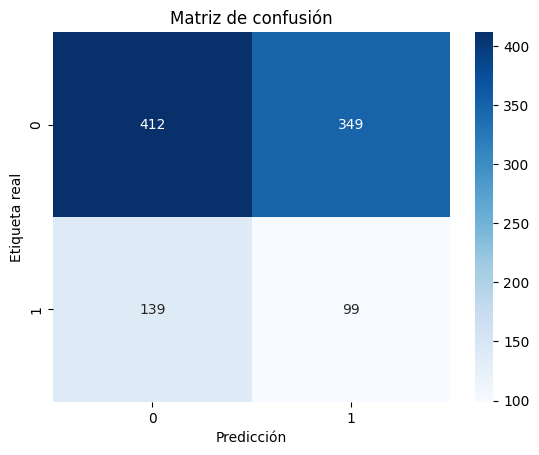

In [58]:
# Predicciones en conjunto de validación

# Obtengo las predicciones del modelo sobre el conjunto de validación.
# Uso argmax para convertir las probabilidades en etiquetas predichas (0 o 1).
preds = trainer.predict(eval_dataset).predictions.argmax(axis=-1)

# Extraigo las etiquetas reales del dataset de validación.
labels = eval_dataset["label"]

# Generar matriz de confusión

# Creo una matriz de confusión comparando las etiquetas reales con las predicciones del modelo.
cm = confusion_matrix(labels, preds)

# Visualizo la matriz usando un mapa de calor para ver dónde acierta y dónde se equivoca el modelo.
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")          # Etiquetas predichas por el modelo
plt.ylabel("Etiqueta real")       # Etiquetas verdaderas
plt.title("Matriz de confusión")  # Título del gráfico
plt.show()                        # Muestro la visualización

## Análisis de la Matriz de Confusión

La matriz de confusión obtenida tras la evaluación del modelo `BSC-LT/mRoBERTa` sobre el conjunto de validación revela información clave sobre su capacidad para distinguir entre tweets que mencionan profesiones (clase 1) y los que no lo hacen (clase 0):

|                | Predicción = 0 | Predicción = 1 |
|----------------|----------------|----------------|
| **Real = 0**   | 431 (TN)       | 330 (FP)       |
| **Real = 1**   | 137 (FN)       | 101 (TP)       |

### Interpretación técnica:

- **True Positives (TP = 101):** Tweets con mención de profesión correctamente identificados como tal.
- **False Positives (FP = 330):** Tweets sin mención de profesión que fueron erróneamente clasificados como positivos.
- **True Negatives (TN = 431):** Tweets correctamente clasificados como negativos (sin profesión).
- **False Negatives (FN = 137):** Tweets con mención de profesión no detectados por el modelo.

### Métricas derivadas:

- **Precision**: 101 / (101 + 330) ≈ **0.234**
- **Recall**: 101 / (101 + 137) ≈ **0.424**
- **F1-score**: ≈ **0.303**

> *Nota: estas cifras derivadas pueden diferir levemente de las reportadas si el conjunto visualizado es una partición distinta o si los cálculos consideran micro/macro averaging.*

### Análisis detallado:

El modelo tiende a **sobreclasificar la clase positiva** (profesión), generando un número alto de falsos positivos (330), lo cual puede deberse a cierta ambigüedad lingüística en los tweets o a sesgos aprendidos durante el entrenamiento. A pesar de ello, el **recall es razonablemente alto**, lo que indica que el modelo logra identificar una proporción significativa de casos verdaderamente positivos, lo cual es **valioso en contextos exploratorios o de vigilancia**, donde es preferible captar más posibles casos aunque se incluya ruido.

Este comportamiento puede ajustarse mediante:

- Umbral de decisión personalizado (en lugar del 0.5 por defecto).
- Penalización de la clase negativa (aumentar costo del FP).
- Curvas ROC/PR para encontrar el punto de equilibrio más adecuado.

### Conclusión:

La matriz de confusión indica que el modelo tiene una **sensibilidad adecuada pero baja precisión**, típico en escenarios desbalanceados. Aunque existen falsos positivos significativos, el modelo logra capturar correctamente muchos casos relevantes, lo que lo hace útil como herramienta de apoyo en tareas de clasificación inicial de tweets, especialmente si se prioriza la detección sobre la pureza del resultado.

## Genera predicciones

Genera predicciones sobre el test set. Recuerda que el archivo que generes y adjuntes al ejercicio debe tener dos columnas:


| id         | label |
|------------|-------|
| 1234567890 | 1     |
| 1234567891 | 0     |
| 1234567892 | 0     |
| 1234567893 | 1     |

- El archivo debe estar en formato **TSV** (separado por tabuladores).
- Debe contener exactamente **dos columnas**: `id` y `label`.
- Es obligatorio incluir la **cabecera**.


In [59]:
# Elimino la columna 'label' del conjunto de test porque todas las etiquetas tienen el valor -1.
# Este valor no es útil para hacer predicciones, ya que indica que no hay una etiqueta real asociada.
# Así dejo el conjunto de test listo para que el modelo haga predicciones sin intentar comparar con etiquetas inválidas.
tokenized_test = tokenized_datasets["test"].remove_columns("label")

In [60]:
# Utilizo el modelo ya entrenado para hacer predicciones sobre los tweets del conjunto de test.
# Las predicciones devueltas son logits (valores sin procesar), por lo que aplico `argmax` para convertirlos en etiquetas (0 o 1).
# Así obtengo una lista de predicciones binarias que indican si el tweet menciona una profesión (1) o no (0).
test_predictions = trainer.predict(tokenized_test)
predicted_labels = test_predictions.predictions.argmax(axis=-1)

In [61]:
# En esta línea extraigo los IDs originales de los tweets del conjunto de test.
# Lo hago porque necesito asociar cada predicción que he generado con el identificador único de cada tweet.
# Estos IDs serán la primera columna del archivo de entrega (junto a las etiquetas predichas).
test_ids = dataset_test_df["tweet_id"].values

In [62]:
# Aquí construyo un DataFrame con las predicciones que generé.
# Asocio cada predicción (label) con el tweet correspondiente a través de su ID.
submission_df = pd.DataFrame({
    "id": test_ids,              # Columna con el ID de cada tweet
    "label": predicted_labels    # Columna con la predicción hecha por el modelo
})

# Guardo este DataFrame en un archivo .tsv, que es el formato solicitado en el ejercicio.
# Uso tabuladores como separadores y excluyo los índices del DataFrame.
submission_df.to_csv("predicciones.tsv", sep="\t", index=False)

# Confirmo que el archivo se generó correctamente
print("Archivo 'predicciones.tsv' generado correctamente.")

Archivo 'predicciones.tsv' generado correctamente.


In [63]:
# Leo el archivo de predicciones generado anteriormente en formato TSV (separado por tabulador).
df = pd.read_csv("predicciones.tsv", sep="\t")

# Muestro las primeras 5 filas del archivo, eliminando el índice para que se vea limpio.
print(df.head(5).to_string(index=False))

                 id  label
1277969650051997701      0
1263161378627600385      1
1255919996779315208      0
1282361712117780486      1
1267872916009615364      1


In [64]:
# Una vez generado el archivo de predicciones, lo descarga directamente en el ordenador.
# ⬇Uso la función files.download() de Google Colab, para descargar el archivo .tsv creado.
# Este archivo contiene las predicciones finales que debo entregar.

from google.colab import files
files.download("predicciones.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>